# Import and Load Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 

# Load Data

In [2]:
train_data = pd.read_csv('../input/bike-share-demand/train.csv')
test_data = pd.read_csv('../input/bike-share-demand/test.csv')

Check null values on train and test data

In [3]:
train_data.isnull().sum()

datetime      0
season        0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [4]:
test_data.isnull().sum()

datetime      0
season        0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

we can see that there are no data that missing, but for the test data there are no variable casual and register

In [5]:
train_data.describe()

,season,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,cnt
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,2.998622,0.680875,1.418427,0.493436,0.473102,0.618865,0.191036,36.021955,155.552177,191.574132
std,1.116174,0.166599,2.007770,0.466159,0.633839,0.190039,0.169492,0.192450,0.121859,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.015200,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.620000,0.194000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,5.000000,1.000000,2.000000,0.640000,0.621200,0.770000,0.253700,49.000000,222.000000,284.000000
max,4.000000,1.000000,6.000000,1.000000,4.000000,1.000000,0.909100,1.000000,0.850700,367.000000,886.000000,977.000000


In [6]:
train_data.head()

,datetime,season,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,cnt
0,2011-01-01 00:00:00,1,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Correlation 

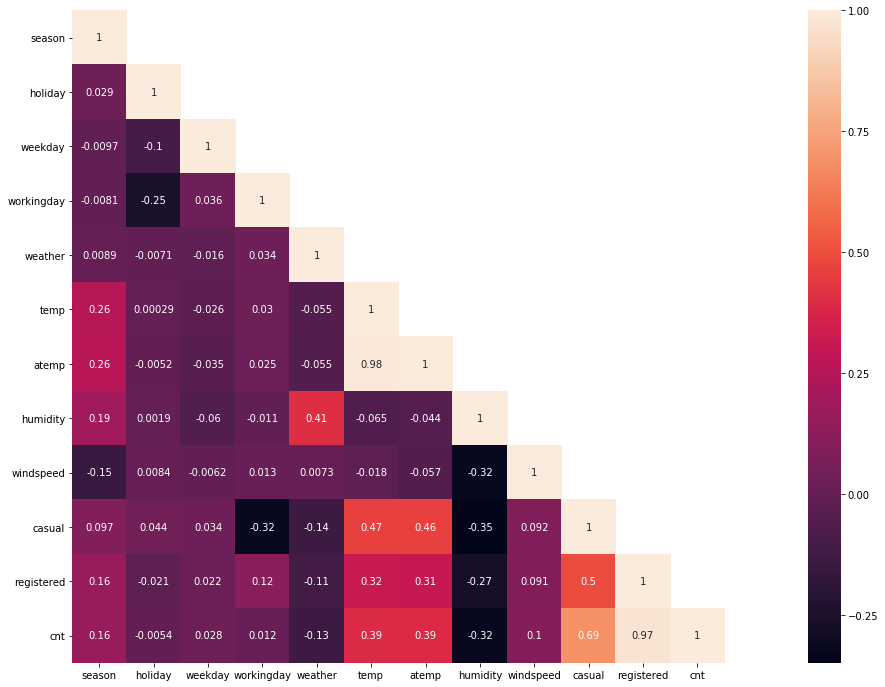

In [7]:
cor_mat= train_data[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

We can see that cnt is highly correlated with casual and register

but If you ignore the cnt feature or only see the relationship between the independent features, then the strongest correlation is 'temp' to 'atemp'. That is because the value of 'atemp' from the beginning seems to be influenced by the temperature value itself. While the strongest inverse correlation for independent features is 'humidity' and 'windspeed' which is natural.

Correlation of predicted with other

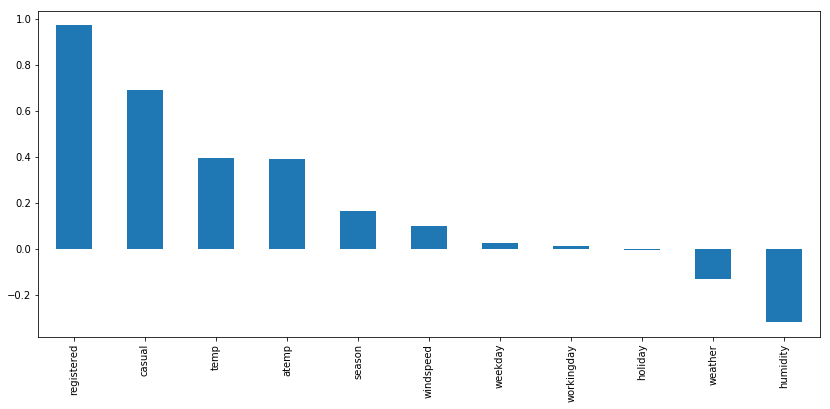

In [8]:
corr_with_cnt = train_data.corr()["cnt"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_cnt.drop("cnt").plot.bar()
plt.show();

temp and attemp have the same correlation score with cnt. And holiday, workingdays and weekday are have low correlation. it is because those variable actualy is categorical variabel not numeric. so we should'nt see the correlation score

# Transform and Preprocess Data

there are some date that can be extracted from datetime with datetime function, and data that are continue need to be changed to discrete

hour and month can be extracted from datetime

In [9]:
train_data['datetime'] = pd.to_datetime(train_data['datetime'])
train_data['year'] = train_data['datetime'].dt.year.astype(str)
train_data['hour'] = train_data['datetime'].dt.hour
train_data['month'] = train_data['datetime'].dt.month
train_data['season'] = train_data['season'].astype(str)
train_data['weather'] = train_data['weather'].astype(str)
train_data['weekday'] = train_data['weekday'].astype(str)
train_data['holiday'] = train_data['holiday'].astype(str)
train_data['workingday'] = train_data['workingday'].astype(str)

test_data['workingday'] = test_data['workingday'].astype(str)
test_data['datetime'] = pd.to_datetime(test_data['datetime'])
test_data['year'] = test_data['datetime'].dt.year.astype(str)
test_data['hour'] = test_data['datetime'].dt.hour
test_data['month'] = test_data['datetime'].dt.month
test_data['season'] = test_data['season'].astype(str)
test_data['weather'] = test_data['weather'].astype(str)
test_data['weekday'] = test_data['weekday'].astype(str)
test_data['holiday'] = test_data['holiday'].astype(str)

In [10]:
train_data.head()

,datetime,season,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,cnt,year,hour,month
0,2011-01-01 00:00:00,1,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011,0,1
1,2011-01-01 01:00:00,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011,1,1
2,2011-01-01 02:00:00,1,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011,2,1
3,2011-01-01 03:00:00,1,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,2011,3,1
4,2011-01-01 04:00:00,1,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,2011,4,1


# Exploratory Data Analysis

[Text(0.5, 1.0, 'Grafik Rata-Rata Jumlah Penyewaan Sepeda Per Jam Tiap Bulan')]

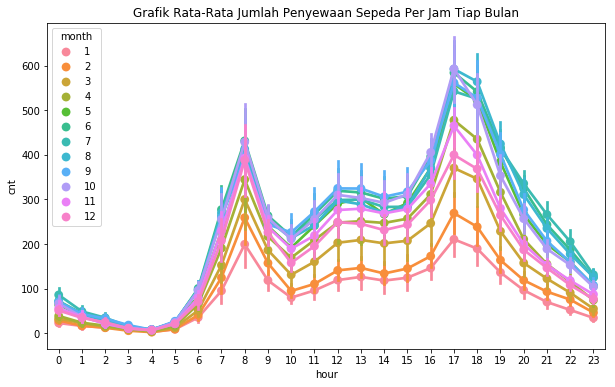

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
sns.pointplot(data=train_data[['hour','cnt','month']],x='hour', y='cnt',hue='month', ax=ax)
ax.set(title="Grafik Rata-Rata Jumlah Penyewaan Sepeda Per Jam Tiap Bulan")

From this graph, we know that there some month that have high average of 'cnt' per hour but the differences is small and there are same pattern for all month

[Text(0.5, 1.0, 'Grafik Rata-Rata Jumlah Penyewaan Sepeda Per Jam Tiap Musim')]

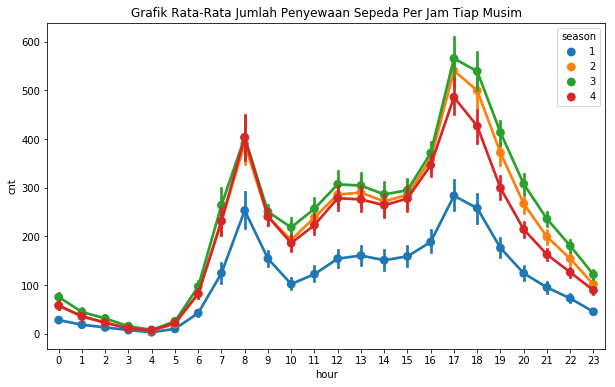

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
sns.pointplot(data=train_data[['hour','cnt','season']],x='hour', y='cnt',hue='season', ax=ax)
ax.set(title="Grafik Rata-Rata Jumlah Penyewaan Sepeda Per Jam Tiap Musim")

From this graph, we know that there some season that have high average of 'cnt' per hour but the differences is small and there are same pattern for all season. And this graph is same with the monthly graph. because one season could be made by some month

[Text(0.5, 1.0, 'Grafik Rata-Rata Jumlah Penyewaan Sepeda Per Jam Tiap Hari')]

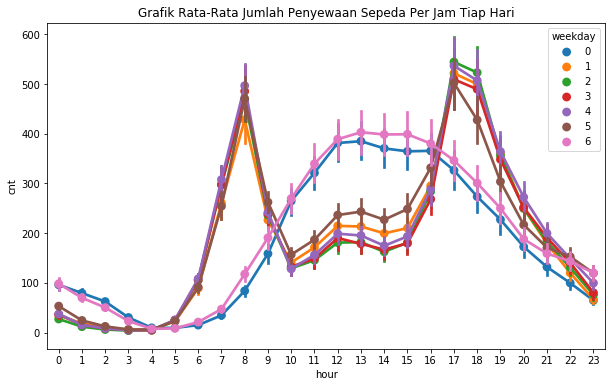

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
sns.pointplot(data=train_data[['hour','cnt','weekday']],x='hour', y='cnt',hue='weekday', ax=ax)
ax.set(title="Grafik Rata-Rata Jumlah Penyewaan Sepeda Per Jam Tiap Hari")

From this graph, we know that there 2 pattern in the week day. weekday 1-5 is the workingday and for 0 and 6 is weekend

[Text(0.5, 1.0, 'Grafik Rata-Rata Jumlah Penyewaan Sepeda Per Jam untuk Hari Libur dan Non Libur')]

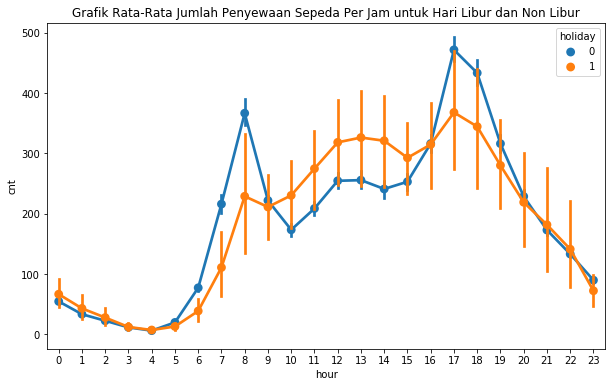

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
sns.pointplot(data=train_data[['hour','cnt','holiday']],x='hour', y='cnt',hue='holiday', ax=ax)
ax.set(title="Grafik Rata-Rata Jumlah Penyewaan Sepeda Per Jam untuk Hari Libur dan Non Libur")

Same with the previous graph, there are pattern for demand bike share system when is holiday(could be weekend) and not holiday( workingdays)

[Text(0.5, 1.0, 'Grafik Rata-Rata Jumlah Penyewaan Sepeda Per Jam Tiap Tahun')]

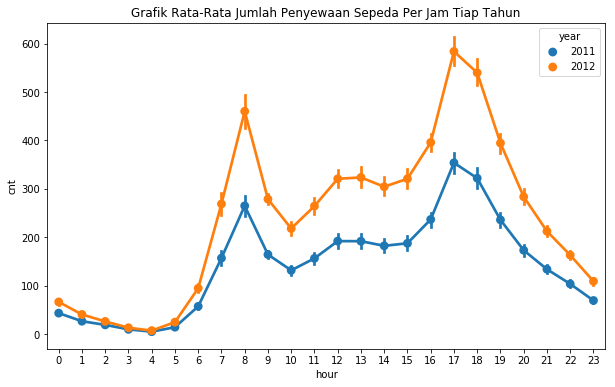

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
sns.pointplot(data=train_data[['hour','cnt','year']],x='hour', y='cnt',hue='year', ax=ax)
ax.set(title="Grafik Rata-Rata Jumlah Penyewaan Sepeda Per Jam Tiap Tahun")

From this graph, we know that for year 2012 the demand is higher than 2011

[Text(0.5, 1.0, 'Grafik Rata-Rata Jumlah Penyewaan Sepeda Per Jam Tiap Cuaca')]

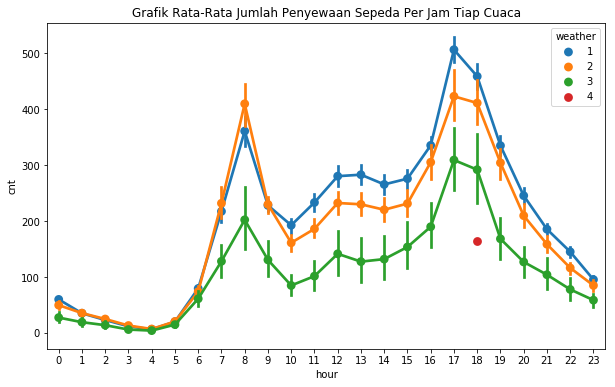

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
sns.pointplot(data=train_data[['hour','cnt','weather']],x='hour', y='cnt',hue='weather', ax=ax)
ax.set(title="Grafik Rata-Rata Jumlah Penyewaan Sepeda Per Jam Tiap Cuaca")

For the weather group, there are small difference, and we could see that for the weather 4 there's only small data

[Text(0.5, 1.0, 'Grafik Rata-Rata Jumlah Penyewaan Sepeda Berdasarkan Temperature Tiap Cuaca')]

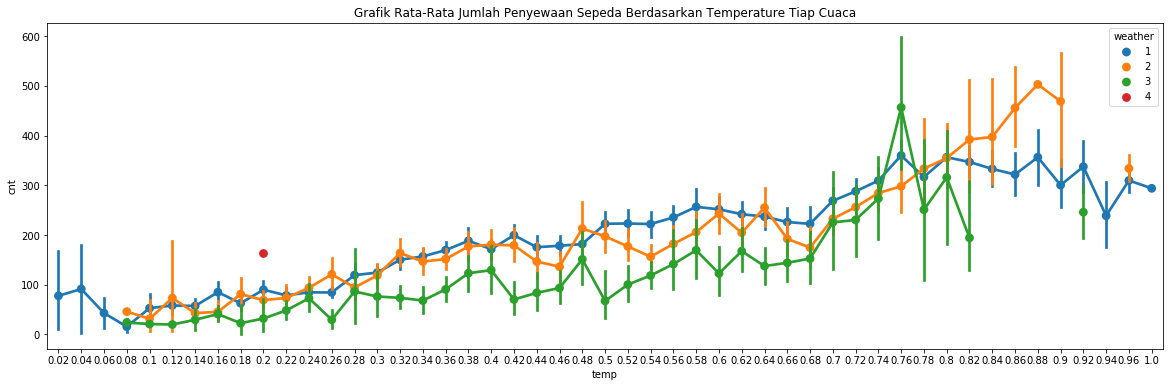

In [17]:
fig, ax = plt.subplots(figsize=(20,6))
sns.pointplot(data=train_data[['temp','cnt','weather']],x='temp', y='cnt',hue='weather', ax=ax)
ax.set(title="Grafik Rata-Rata Jumlah Penyewaan Sepeda Berdasarkan Temperature Tiap Cuaca")

From this graph we could see that for the higher temp, the demand or use of bike is increased. it is because people are lazy to use bike when the temp is low because the weather is to cold for riding a bike

[Text(0.5, 1.0, 'Grafik Rata-Rata Jumlah Penyewaan Sepeda Berdasarkan Kelembabapan Tiap Musim')]

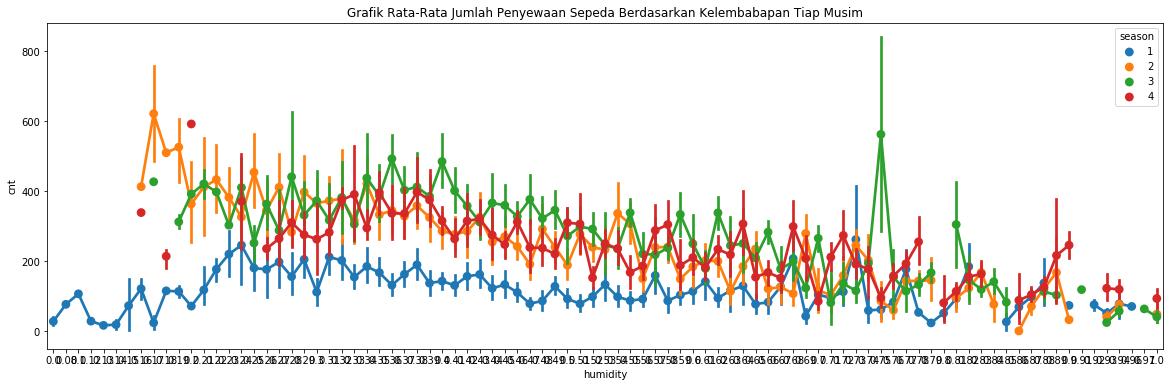

In [18]:
fig, ax = plt.subplots(figsize=(20,6))
sns.pointplot(data=train_data[['humidity','cnt','season']],x='humidity', y='cnt',hue='season', ax=ax)
ax.set(title="Grafik Rata-Rata Jumlah Penyewaan Sepeda Berdasarkan Kelembabapan Tiap Musim")

From this graph, we couldn't see any corelation beetween season humidity and cnt

[Text(0.5, 1.0, 'Rata-Rata Jumlah Penyewaan Sepeda Per Bulan')]

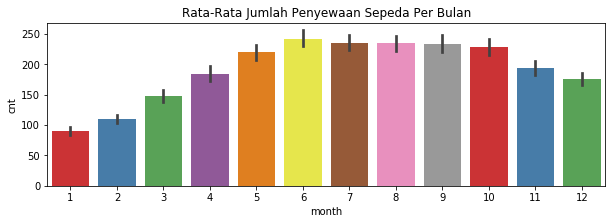

In [19]:
fig, ax = plt.subplots(figsize=(10,3))
sns.barplot(x='month', y='cnt', data=train_data, palette='Set1',orient='v', ax=ax)
ax.set(title="Rata-Rata Jumlah Penyewaan Sepeda Per Bulan")

From this bar plot we can see that the higher average of cnt is in the month 5-10

[Text(0.5, 1.0, 'Rata-Rata Jumlah Penyewaan Sepeda Per Jam')]

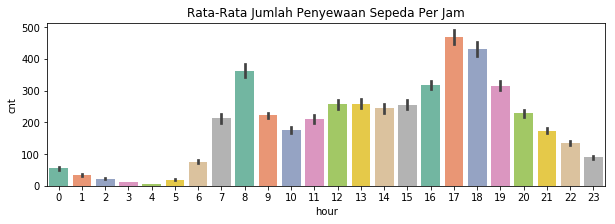

In [20]:
fig, ax = plt.subplots(figsize=(10,3))
sns.barplot(x='hour', y='cnt', data=train_data, palette='Set2',orient='v', ax=ax)
ax.set(title="Rata-Rata Jumlah Penyewaan Sepeda Per Jam")

From this bar plot and we know that there are peak hour of the use of bike share demand, that is 8, 17 and 18. those hour is the hour of working people to go to the office and the hour of going home from the office. and we could see that from the hour 0 to 6 the average cnt is small it is because people still sleep or having no activity

# Feature Engineering

# 1. Feature Selection

Delete 'atemp' because it same with 'temp', and delete 'casual' and 'registered' because the test data don't have this data. and delete 'month' beacause the month could be represented by season

In [21]:
del train_data['atemp'] , train_data['month'],train_data['casual'], train_data['registered']
del test_data['atemp'], test_data['month']

# 2. Feature Engineering

Create the hour grouup, that is grouped of hour data from the number average of count

In [22]:
def hour_group(s):
    if((0<=s) & (s<=6)):
        return 1
    elif((7<=s) & (s<=11)):
        return 2
    elif((s==8)):
        return 3
    elif((12<=s) & (s<=15)):
        return 4
    elif((s==16) | (s==19)):
        return 5
    elif((s==17) | (s==18)):
        return 6
    elif((s==21) | (s==20)):
        return 2
    else : return 7

In [23]:
train_data['hour_group'] = train_data['hour'].apply(hour_group).astype(str)
test_data['hour_group'] = test_data['hour'].apply(hour_group).astype(str)

In [24]:
train_data.head()

,datetime,season,holiday,weekday,workingday,weather,temp,humidity,windspeed,cnt,year,hour,hour_group
0,2011-01-01 00:00:00,1,0,6,0,1,0.24,0.81,0.0,16,2011,0,1
1,2011-01-01 01:00:00,1,0,6,0,1,0.22,0.80,0.0,40,2011,1,1
2,2011-01-01 02:00:00,1,0,6,0,1,0.22,0.80,0.0,32,2011,2,1
3,2011-01-01 03:00:00,1,0,6,0,1,0.24,0.75,0.0,13,2011,3,1
4,2011-01-01 04:00:00,1,0,6,0,1,0.24,0.75,0.0,1,2011,4,1


Select Target Variable

In [25]:
y_train = train_data['cnt']
X_train = train_data.copy()
del X_train['cnt'], X_train['datetime']
X_test = test_data.copy()
del X_test['datetime']

In [26]:
ntrain = X_train.shape[0]
all_data = pd.concat((X_train, X_test)).reset_index(drop=True)
all_data.head()

,season,holiday,weekday,workingday,weather,temp,humidity,windspeed,year,hour,hour_group
0,1,0,6,0,1,0.24,0.81,0.0,2011,0,1
1,1,0,6,0,1,0.22,0.80,0.0,2011,1,1
2,1,0,6,0,1,0.22,0.80,0.0,2011,2,1
3,1,0,6,0,1,0.24,0.75,0.0,2011,3,1
4,1,0,6,0,1,0.24,0.75,0.0,2011,4,1


Dummy / One Hot Encoding

In [27]:
all_data2 = pd.get_dummies(all_data)

Get the n-1 feature or drop 1 feature from one hot encoding

In [28]:
all_data2 = all_data2.drop(['weather_4','weekday_3','holiday_0','year_2012','season_2','hour_group_7'], axis =1)
all_data2.head()

,temp,humidity,windspeed,hour,season_1,season_3,season_4,holiday_1,weekday_0,weekday_1,weekday_2,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weather_1,weather_2,weather_3,year_2011,hour_group_1,hour_group_2,hour_group_4,hour_group_5,hour_group_6
0,0.24,0.81,0.0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,0,0
1,0.22,0.80,0.0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,0,0
2,0.22,0.80,0.0,2,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,0,0
3,0.24,0.75,0.0,3,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,0,0
4,0.24,0.75,0.0,4,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,0,0


# 3. Feature Scaling

The data neet to be scale with minmax scaler before put it to the model, and for the predicted variable we should see the distribution of variabel. if variable didn't have normal distribution. we should transform the variable

In [29]:
x = all_data2.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dfminmax = pd.DataFrame(x_scaled)
dfminmax.columns = all_data2.columns

X_train = dfminmax[:ntrain]
X_test = dfminmax[ntrain:]  

In [30]:
X_train.head()

,temp,humidity,windspeed,hour,season_1,season_3,season_4,holiday_1,weekday_0,weekday_1,weekday_2,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weather_1,weather_2,weather_3,year_2011,hour_group_1,hour_group_2,hour_group_4,hour_group_5,hour_group_6
0,0.224490,0.81,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.204082,0.80,0.0,0.043478,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.204082,0.80,0.0,0.086957,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.224490,0.75,0.0,0.130435,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.224490,0.75,0.0,0.173913,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


[Text(0.5, 1.0, 'Distribution after log of count')]

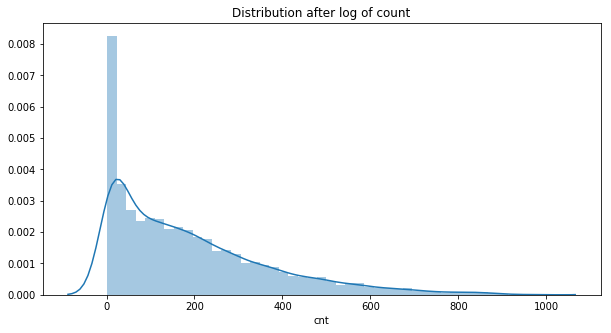

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(y_train, ax=ax)
ax.set(title="Distribution after log of count")

we can see that target data is have left skewneww. net to be transform to normal distribution

transform train_target to normal distribution

In [32]:
y_train = np.log1p(y_train)

[Text(0.5, 1.0, 'Distribution after log of count')]

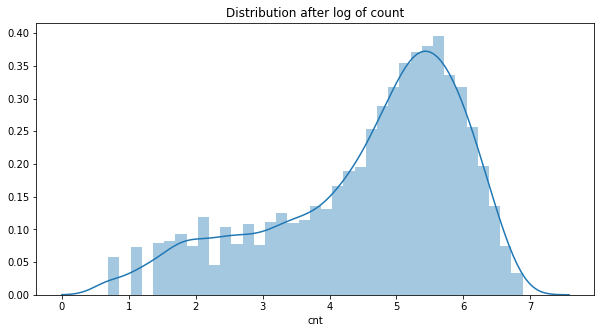

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(y_train, ax=ax)
ax.set(title="Distribution after log of count")

In [34]:
y_train.head()

0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: cnt, dtype: float64

# Metrics Evaluation and Cross Validation

make a cross validation with 5 kfold

In [35]:
skf = KFold(n_splits=5, random_state = 1, shuffle = False)

make a function to calculate rmsle

In [36]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

make a function that display the score of each metrics (average) on cv

In [37]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# Model Construction

model-design.jpg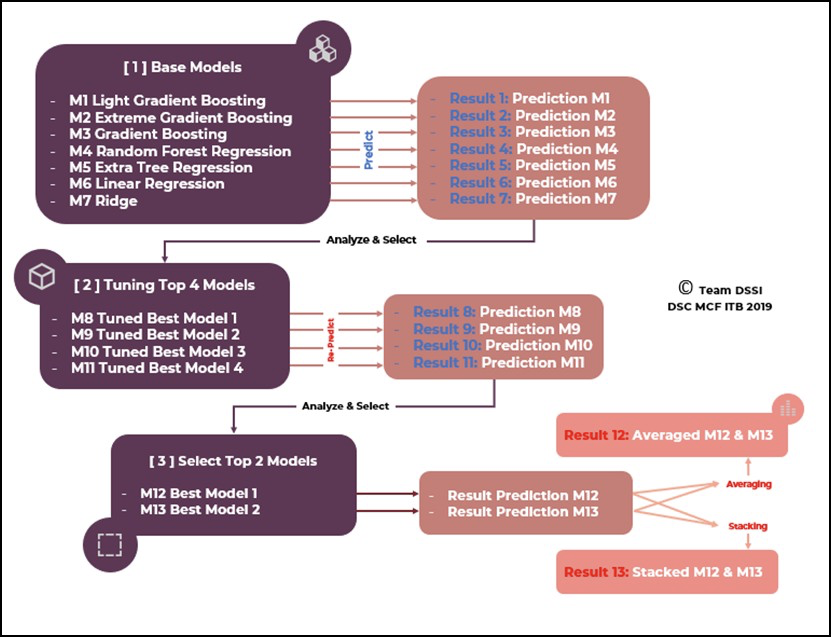

For predicting the result first we choose seven model and predict the result, after that we choose top 4 best model from the evaluation metrics on test data. this 4 model would have tunning parameters step to increase the accurracy of model and decrease the error. the top 2 model from the tunning step will be choosen and we will use another method that is averaging and stacking. From all of those method we choose model with the lowest error on the RMSLE

# Base Model

1. GradientBoosting
2. LightGBM
3. XGBoost
4. RandomForest
5. ExtraTrees
6. LinearRegression
7. Ridge

In [38]:
rmsle_scores = []
rmsle_scores_train = []
for train_index, test_index in skf.split(X_train):
    
    print('')
    print("Train:", train_index, "Validation:",test_index)
    train, test = X_train.iloc[train_index], X_train.iloc[test_index] 
    traintarget, testtarget = y_train.iloc[train_index], y_train.iloc[test_index]

    best_xgb = xgb.XGBRegressor()
    best_xgb.fit(train, traintarget)
    
    train_predictions = best_xgb.predict(train)
    train_rmsle = rmsle(np.exp(train_predictions),np.exp(traintarget),False)
    print("Train RMSLE Score Base XGB: " ,train_rmsle)
    rmsle_scores_train.append(train_rmsle)
    
    val_predictions = best_xgb.predict(test)
    val_rmsle = rmsle(np.exp(val_predictions),np.exp(testtarget),False)
    print("Validation RMSLE Score Base XGB: " ,val_rmsle)
    print('')
    
    rmsle_scores.append(val_rmsle)
    testtarget = np.exp(testtarget)
    val_predictions = np.exp(val_predictions)
    df = pd.DataFrame(data={'act':testtarget,'pred':val_predictions})
    print(df.head())

print('')    
print('rmsle train')
display_scores(np.asarray(rmsle_scores_train))
print('')    
print('rmsle test')
display_scores(np.asarray(rmsle_scores))
print('')


Train: [ 2178  2179  2180 ... 10883 10884 10885] Validation: [   0    1    2 ... 2175 2176 2177]
[12:40:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSLE Score Base XGB:  0.3819211382834229
Validation RMSLE Score Base XGB:  0.6921001062096136

    act       pred
0  17.0  52.201900
1  41.0  36.490410
2  33.0  22.025267
3  14.0  10.328101
4   2.0   6.473086

Train: [    0     1     2 ... 10883 10884 10885] Validation: [2178 2179 2180 ... 4352 4353 4354]
[12:40:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSLE Score Base XGB:  0.39584120947697815
Validation RMSLE Score Base XGB:  0.4055623131321989

        act        pred
2178  291.0  260.070343
2179  605.0  448.763214
2180  481.0  448.763214
2181  350.0  277.693573
2182  284.0  160.523621

Train: [    0     1     2 ... 10883 10884 10885] Validation: [4355 4356 4357 ... 6529 

In [39]:
rmsle_scores = []
rmsle_scores_train = []
for train_index, test_index in skf.split(X_train):
    
    print('')
    print("Train:", train_index, "Validation:",test_index)
    train, test = X_train.iloc[train_index], X_train.iloc[test_index] 
    traintarget, testtarget = y_train.iloc[train_index], y_train.iloc[test_index]

    best_lgb = lgb.LGBMRegressor()
    best_lgb.fit(train, traintarget)
    
    train_predictions = best_lgb.predict(train)
    train_rmsle = rmsle(np.exp(train_predictions),np.exp(traintarget),False)
    print("Train RMSLE Score Base LGB: " ,train_rmsle)
    rmsle_scores_train.append(train_rmsle)
    
    val_predictions = best_lgb.predict(test)
    val_rmsle = rmsle(np.exp(val_predictions),np.exp(testtarget),False)
    print("Validation RMSLE Score Base LGB: " ,val_rmsle)
    print('')
    
    rmsle_scores.append(val_rmsle)
    testtarget = np.exp(testtarget)
    val_predictions = np.exp(val_predictions)
    df = pd.DataFrame(data={'act':testtarget,'pred':val_predictions})
    print(df.head())

print('')    
print('rmsle train')
display_scores(np.asarray(rmsle_scores_train))
print('')    
print('rmsle test')
display_scores(np.asarray(rmsle_scores))
print('')


Train: [ 2178  2179  2180 ... 10883 10884 10885] Validation: [   0    1    2 ... 2175 2176 2177]
Train RMSLE Score Base LGB:  0.22256739356135688
Validation RMSLE Score Base LGB:  0.611808350509536

    act       pred
0  17.0  50.130088
1  41.0  43.365287
2  33.0  28.582624
3  14.0  13.750425
4   2.0   5.860773

Train: [    0     1     2 ... 10883 10884 10885] Validation: [2178 2179 2180 ... 4352 4353 4354]
Train RMSLE Score Base LGB:  0.2438264854301645
Validation RMSLE Score Base LGB:  0.31364760909322276

        act        pred
2178  291.0  248.442892
2179  605.0  475.828600
2180  481.0  456.746757
2181  350.0  305.203645
2182  284.0  186.300234

Train: [    0     1     2 ... 10883 10884 10885] Validation: [4355 4356 4357 ... 6529 6530 6531]
Train RMSLE Score Base LGB:  0.2374915544077057
Validation RMSLE Score Base LGB:  0.35925004558569434

        act        pred
4355  106.0  118.097617
4356  163.0  161.385366
4357  134.0  190.782571
4358  156.0  197.713339
4359  277.0  296.003

In [40]:
rmsle_scores = []
rmsle_scores_train = []
for train_index, test_index in skf.split(X_train):
    
    print('')
    print("Train:", train_index, "Validation:",test_index)
    train, test = X_train.iloc[train_index], X_train.iloc[test_index] 
    traintarget, testtarget = y_train.iloc[train_index], y_train.iloc[test_index]

    best_rf = RandomForestRegressor()
    best_rf.fit(train, traintarget)
    
    train_predictions = best_rf.predict(train)
    train_rmsle = rmsle(np.exp(train_predictions),np.exp(traintarget),False)
    print("Train RMSLE Score Base RF: " ,train_rmsle)
    rmsle_scores_train.append(train_rmsle)
    
    val_predictions = best_rf.predict(test)
    val_rmsle = rmsle(np.exp(val_predictions),np.exp(testtarget),False)
    print("Validation RMSLE Score Base RF: " ,val_rmsle)
    print('')
    
    rmsle_scores.append(val_rmsle)
    testtarget = np.exp(testtarget)
    val_predictions = np.exp(val_predictions)
    df = pd.DataFrame(data={'act':testtarget,'pred':val_predictions})
    print(df.head())

print('')    
print('rmsle train')
display_scores(np.asarray(rmsle_scores_train))
print('')    
print('rmsle test')
display_scores(np.asarray(rmsle_scores))
print('')


Train: [ 2178  2179  2180 ... 10883 10884 10885] Validation: [   0    1    2 ... 2175 2176 2177]
Train RMSLE Score Base RF:  0.12246830592146085
Validation RMSLE Score Base RF:  0.6746891455636067

    act       pred
0  17.0  57.200832
1  41.0  60.084019
2  33.0  47.497447
3  14.0  19.048593
4   2.0   7.250344

Train: [    0     1     2 ... 10883 10884 10885] Validation: [2178 2179 2180 ... 4352 4353 4354]
Train RMSLE Score Base RF:  0.1314937352846405
Validation RMSLE Score Base RF:  0.36590589544096963

        act        pred
2178  291.0  279.522947
2179  605.0  487.977059
2180  481.0  441.218456
2181  350.0  322.314928
2182  284.0  167.521019

Train: [    0     1     2 ... 10883 10884 10885] Validation: [4355 4356 4357 ... 6529 6530 6531]
Train RMSLE Score Base RF:  0.131368259357486
Validation RMSLE Score Base RF:  0.5469855322783832

        act        pred
4355  106.0  125.892222
4356  163.0  125.453045
4357  134.0  181.631382
4358  156.0  187.215619
4359  277.0  316.776779

Tr

In [41]:
rmsle_scores = []
rmsle_scores_train = []
for train_index, test_index in skf.split(X_train):
    
    print('')
    print("Train:", train_index, "Validation:",test_index)
    train, test = X_train.iloc[train_index], X_train.iloc[test_index] 
    traintarget, testtarget = y_train.iloc[train_index], y_train.iloc[test_index]

    best_et = ExtraTreesRegressor()
    best_et.fit(train, traintarget)
    
    train_predictions = best_et.predict(train)
    train_rmsle = rmsle(np.exp(train_predictions),np.exp(traintarget),False)
    print("Train RMSLE Score Base ET: " ,train_rmsle)
    rmsle_scores_train.append(train_rmsle)
    
    val_predictions = best_et.predict(test)
    val_rmsle = rmsle(np.exp(val_predictions),np.exp(testtarget),False)
    print("Validation RMSLE Score Base ET: " ,val_rmsle)
    print('')
    
    rmsle_scores.append(val_rmsle)
    testtarget = np.exp(testtarget)
    val_predictions = np.exp(val_predictions)
    df = pd.DataFrame(data={'act':testtarget,'pred':val_predictions})
    print(df.head())

print('')    
print('rmsle train')
display_scores(np.asarray(rmsle_scores_train))
print('')    
print('rmsle test')
display_scores(np.asarray(rmsle_scores))
print('')


Train: [ 2178  2179  2180 ... 10883 10884 10885] Validation: [   0    1    2 ... 2175 2176 2177]
Train RMSLE Score Base ET:  0.013825799256061052
Validation RMSLE Score Base ET:  0.7204988941771324

    act       pred
0  17.0  63.105068
1  41.0  48.394710
2  33.0  42.318333
3  14.0  15.419958
4   2.0   7.846924

Train: [    0     1     2 ... 10883 10884 10885] Validation: [2178 2179 2180 ... 4352 4353 4354]
Train RMSLE Score Base ET:  0.01401413010900166
Validation RMSLE Score Base ET:  0.3916268724308558

        act        pred
2178  291.0  295.957089
2179  605.0  494.347790
2180  481.0  458.474409
2181  350.0  348.691411
2182  284.0  187.977086

Train: [    0     1     2 ... 10883 10884 10885] Validation: [4355 4356 4357 ... 6529 6530 6531]
Train RMSLE Score Base ET:  0.0035552405571507863
Validation RMSLE Score Base ET:  0.5343013143514911

        act        pred
4355  106.0  130.210460
4356  163.0  114.957878
4357  134.0  158.989474
4358  156.0  183.710600
4359  277.0  312.19766

In [42]:
rmsle_scores = []
rmsle_scores_train = []
for train_index, test_index in skf.split(X_train):
    
    print('')
    print("Train:", train_index, "Validation:",test_index)
    train, test = X_train.iloc[train_index], X_train.iloc[test_index] 
    traintarget, testtarget = y_train.iloc[train_index], y_train.iloc[test_index]

    best_gb = GradientBoostingRegressor()
    best_gb.fit(train, traintarget)
    
    train_predictions = best_gb.predict(train)
    train_rmsle = rmsle(np.exp(train_predictions),np.exp(traintarget),False)
    print("Train RMSLE Score Base GB: " ,train_rmsle)
    rmsle_scores_train.append(train_rmsle)
    
    val_predictions = best_gb.predict(test)
    val_rmsle = rmsle(np.exp(val_predictions),np.exp(testtarget),False)
    print("Validation RMSLE Score Base GB: " ,val_rmsle)
    print('')
    
    rmsle_scores.append(val_rmsle)
    testtarget = np.exp(testtarget)
    val_predictions = np.exp(val_predictions)
    df = pd.DataFrame(data={'act':testtarget,'pred':val_predictions})
    print(df.head())

print('')    
print('rmsle train')
display_scores(np.asarray(rmsle_scores_train))
print('')    
print('rmsle test')
display_scores(np.asarray(rmsle_scores))
print('')


Train: [ 2178  2179  2180 ... 10883 10884 10885] Validation: [   0    1    2 ... 2175 2176 2177]
Train RMSLE Score Base GB:  0.38543890184051643
Validation RMSLE Score Base GB:  0.6961241886659824

    act       pred
0  17.0  57.449517
1  41.0  37.532386
2  33.0  21.685942
3  14.0  10.072285
4   2.0   5.644694

Train: [    0     1     2 ... 10883 10884 10885] Validation: [2178 2179 2180 ... 4352 4353 4354]
Train RMSLE Score Base GB:  0.40334247627927833
Validation RMSLE Score Base GB:  0.4129163462924631

        act        pred
2178  291.0  271.136810
2179  605.0  420.806045
2180  481.0  420.806045
2181  350.0  269.809808
2182  284.0  164.404337

Train: [    0     1     2 ... 10883 10884 10885] Validation: [4355 4356 4357 ... 6529 6530 6531]
Train RMSLE Score Base GB:  0.4127413587921713
Validation RMSLE Score Base GB:  0.5213297149854137

        act        pred
4355  106.0  192.780529
4356  163.0  202.245151
4357  134.0  211.928209
4358  156.0  211.928209
4359  277.0  324.958600

T

In [43]:
rmsle_scores = []
rmsle_scores_train = []
for train_index, test_index in skf.split(X_train):
    
    print('')
    print("Train:", train_index, "Validation:",test_index)
    train, test = X_train.iloc[train_index], X_train.iloc[test_index] 
    traintarget, testtarget = y_train.iloc[train_index], y_train.iloc[test_index]

    best_lr = LinearRegression()
    best_lr.fit(train, traintarget)
    
    train_predictions = best_lr.predict(train)
    train_rmsle = rmsle(np.exp(train_predictions),np.exp(traintarget),False)
    print("Train RMSLE Score Base LR: " ,train_rmsle)
    rmsle_scores_train.append(train_rmsle)
    
    val_predictions = best_lr.predict(test)
    val_rmsle = rmsle(np.exp(val_predictions),np.exp(testtarget),False)
    print("Validation RMSLE Score Base LR: " ,val_rmsle)
    print('')
    
    rmsle_scores.append(val_rmsle)
    testtarget = np.exp(testtarget)
    val_predictions = np.exp(val_predictions)
    df = pd.DataFrame(data={'act':testtarget,'pred':val_predictions})
    print(df.head())

print('')    
print('rmsle train')
display_scores(np.asarray(rmsle_scores_train))
print('')    
print('rmsle test')
display_scores(np.asarray(rmsle_scores))
print('')


Train: [ 2178  2179  2180 ... 10883 10884 10885] Validation: [   0    1    2 ... 2175 2176 2177]
Train RMSLE Score Base LR:  0.6796644056588008
Validation RMSLE Score Base LR:  0.7066144826672441

    act       pred
0  17.0  11.400682
1  41.0  11.036681
2  33.0  10.911923
3  14.0  11.208393
4   2.0  11.081693

Train: [    0     1     2 ... 10883 10884 10885] Validation: [2178 2179 2180 ... 4352 4353 4354]
Train RMSLE Score Base LR:  0.6799398531716379
Validation RMSLE Score Base LR:  0.6928787201110085

        act        pred
2178  291.0  235.925445
2179  605.0  319.326622
2180  481.0  313.900569
2181  350.0  219.475423
2182  284.0  129.028964

Train: [    0     1     2 ... 10883 10884 10885] Validation: [4355 4356 4357 ... 6529 6530 6531]
Train RMSLE Score Base LR:  0.6735606367293152
Validation RMSLE Score Base LR:  inf

        act        pred
4355  106.0  222.903353
4356  163.0  220.091412
4357  134.0  240.545715
4358  156.0  237.975557
4359  277.0  327.745151

Train: [    0     

In [44]:
rmsle_scores = []
rmsle_scores_train = []
for train_index, test_index in skf.split(X_train):
    
    print('')
    print("Train:", train_index, "Validation:",test_index)
    train, test = X_train.iloc[train_index], X_train.iloc[test_index] 
    traintarget, testtarget = y_train.iloc[train_index], y_train.iloc[test_index]

    best_r = Ridge()
    best_r.fit(train, traintarget)
    
    train_predictions = best_r.predict(train)
    train_rmsle = rmsle(np.exp(train_predictions),np.exp(traintarget),False)
    print("Train RMSLE Score Base Ridge: " ,train_rmsle)
    rmsle_scores_train.append(train_rmsle)
    
    val_predictions = best_r.predict(test)
    val_rmsle = rmsle(np.exp(val_predictions),np.exp(testtarget),False)
    print("Validation RMSLE Score Base Ridge: " ,val_rmsle)
    print('')
    
    rmsle_scores.append(val_rmsle)
    testtarget = np.exp(testtarget)
    val_predictions = np.exp(val_predictions)
    df = pd.DataFrame(data={'act':testtarget,'pred':val_predictions})
    print(df.head())

print('')    
print('rmsle train')
display_scores(np.asarray(rmsle_scores_train))
print('')    
print('rmsle test')
display_scores(np.asarray(rmsle_scores))
print('')


Train: [ 2178  2179  2180 ... 10883 10884 10885] Validation: [   0    1    2 ... 2175 2176 2177]
Train RMSLE Score Base Ridge:  0.6796553076327712
Validation RMSLE Score Base Ridge:  0.707035599843556

    act       pred
0  17.0  11.402496
1  41.0  11.043457
2  33.0  10.921397
3  14.0  11.219697
4   2.0  11.095690

Train: [    0     1     2 ... 10883 10884 10885] Validation: [2178 2179 2180 ... 4352 4353 4354]
Train RMSLE Score Base Ridge:  0.679930172686864
Validation RMSLE Score Base Ridge:  0.6926978610729829

        act        pred
2178  291.0  235.383002
2179  605.0  318.595559
2180  481.0  313.204889
2181  350.0  219.143411
2182  284.0  129.228107

Train: [    0     1     2 ... 10883 10884 10885] Validation: [4355 4356 4357 ... 6529 6530 6531]
Train RMSLE Score Base Ridge:  0.6735205902475327
Validation RMSLE Score Base Ridge:  0.7064915453470983

        act        pred
4355  106.0  224.083517
4356  163.0  221.149160
4357  134.0  242.309157
4358  156.0  239.884758
4359  277.0 

Top Base Model based on error is:

1. LightGBM 0.38479755778267194
2. Random Forest 0.4613737726885111
3. Extra Trees 0.4642655507934944
4. XGBoost 0.48462642413992557
5. Gradient Boosting 0.4929716699990919
6. Ridge 0.6960069983717179
7. Linear Regression 0.695979757724483

# Tunning Parameter

For top 4 base model we tunned the parameter of each model, to improve the prediction or lower the error

XGBoost

In [45]:
rmsle_scores = []
rmsle_scores_train = []

for train_index, test_index in skf.split(X_train):
    
    print('')
    print("Train:", train_index, "Validation:",test_index)
    train, test = X_train.iloc[train_index], X_train.iloc[test_index] 
    traintarget, testtarget = y_train.iloc[train_index], y_train.iloc[test_index]

    best_xgb =xgb.XGBRegressor(
       colsample_bytree=0.4, gamma=0.2, 
                             learning_rate=0.05, max_depth=4, 
                              n_estimators=3000
    )
    best_xgb.fit(train, traintarget)
    
    train_predictions = best_xgb.predict(train)
    train_rmsle = rmsle(np.exp(train_predictions),np.exp(traintarget),False)
    print("Train RMSLE Score Tunned XGB: " ,train_rmsle)
    rmsle_scores_train.append(train_rmsle)
    
    val_predictions = best_xgb.predict(test)
    val_rmsle = rmsle(np.exp(val_predictions),np.exp(testtarget),False)
    
    print("Validation RMSLE Score Tunned XGB: " ,val_rmsle)
    print('')
    
    rmsle_scores.append(val_rmsle)
    testtarget = np.exp(testtarget)
    val_predictions = np.exp(val_predictions)
    df = pd.DataFrame(data={'act':testtarget,'pred':val_predictions})
    print(df.head())

print('')    
print('rmsle train')
display_scores(np.asarray(rmsle_scores_train))
print('')    
print('rmsle test')
display_scores(np.asarray(rmsle_scores))
print('')


Train: [ 2178  2179  2180 ... 10883 10884 10885] Validation: [   0    1    2 ... 2175 2176 2177]
[12:40:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSLE Score Tunned XGB:  0.21850823096002409
Validation RMSLE Score Tunned XGB:  0.5576645881916366

    act       pred
0  17.0  51.670124
1  41.0  39.983402
2  33.0  28.433981
3  14.0  14.269198
4   2.0   5.079045

Train: [    0     1     2 ... 10883 10884 10885] Validation: [2178 2179 2180 ... 4352 4353 4354]
[12:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSLE Score Tunned XGB:  0.24206329057910522
Validation RMSLE Score Tunned XGB:  0.2799267900700615

        act        pred
2178  291.0  243.397781
2179  605.0  495.862823
2180  481.0  446.079102
2181  350.0  328.661926
2182  284.0  188.986816

Train: [    0     1     2 ... 10883 10884 10885] Validation: [4355 4356 4357 

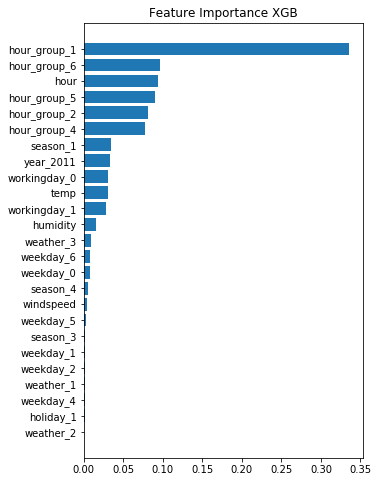

In [46]:
# Get sorted list of features in order of importance
feature_indices = np.argsort(best_xgb.feature_importances_)
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::1]
names = [X_train.columns[i] for i in indices]
# Create plot
plt.figure(figsize=(5,8))

# Create plot title
plt.title("Feature Importance XGB")

# Add bars
plt.barh(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.yticks(range(X_train.shape[1]), names)

# Show plot
plt.show()

LightGBM

In [47]:
rmsle_scores = []
rmsle_scores_train = []
for train_index, test_index in skf.split(X_train):
    
    print('')
    print("Train:", train_index, "Validation:",test_index)
    train, test = X_train.iloc[train_index], X_train.iloc[test_index] 
    traintarget, testtarget = y_train.iloc[train_index], y_train.iloc[test_index]

    best_lgb =  lgb.LGBMRegressor(
        objective='regression',learning_rate=0.01, 
                                  n_estimators=2000, num_leaves=40, 
                                  max_depth=8, colsample_bytree=0.3)
    
    best_lgb.fit(train, traintarget)
    train_predictions = best_lgb.predict(train)
    train_rmsle = rmsle(np.exp(train_predictions),np.exp(traintarget),False)
    print("Train RMSLE Score Tunned LGB: " ,train_rmsle)
    rmsle_scores_train.append(train_rmsle)
    
    val_predictions = best_lgb.predict(test)
    val_rmsle = rmsle(np.exp(val_predictions),np.exp(testtarget),False)
    print("Validation RMSLE Score Tunned LGB: " ,val_rmsle)
    print('')
    
    rmsle_scores.append(val_rmsle)
    testtarget = np.exp(testtarget)
    val_predictions = np.exp(val_predictions)
    df = pd.DataFrame(data={'act':testtarget,'pred':val_predictions})
    print(df.head())

print('')    
print('rmsle train')
display_scores(np.asarray(rmsle_scores_train))
print('')    
print('rmsle test')
display_scores(np.asarray(rmsle_scores))
print('')


Train: [ 2178  2179  2180 ... 10883 10884 10885] Validation: [   0    1    2 ... 2175 2176 2177]
Train RMSLE Score Tunned LGB:  0.21600899713055172
Validation RMSLE Score Tunned LGB:  0.54992600350411

    act       pred
0  17.0  50.459871
1  41.0  34.093757
2  33.0  26.198106
3  14.0  13.042224
4   2.0   4.948620

Train: [    0     1     2 ... 10883 10884 10885] Validation: [2178 2179 2180 ... 4352 4353 4354]
Train RMSLE Score Tunned LGB:  0.23104630976158158
Validation RMSLE Score Tunned LGB:  0.28505715711390905

        act        pred
2178  291.0  240.711605
2179  605.0  461.809680
2180  481.0  449.081918
2181  350.0  318.177860
2182  284.0  167.283172

Train: [    0     1     2 ... 10883 10884 10885] Validation: [4355 4356 4357 ... 6529 6530 6531]
Train RMSLE Score Tunned LGB:  0.22810298373838173
Validation RMSLE Score Tunned LGB:  0.30382935707610914

        act        pred
4355  106.0  154.857621
4356  163.0  164.550609
4357  134.0  200.793456
4358  156.0  209.811331
4359  2

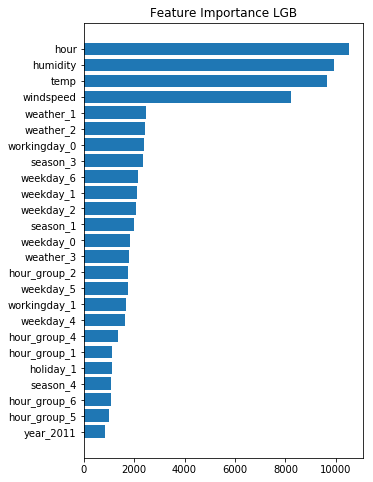

In [48]:
# Get sorted list of features in order of importance
feature_indices = np.argsort(best_lgb.feature_importances_)
importances = best_lgb.feature_importances_
indices = np.argsort(importances)[::1]
names = [X_train.columns[i] for i in indices]
# Create plot
plt.figure(figsize=(5,8))

# Create plot title
plt.title("Feature Importance LGB")

# Add bars
plt.barh(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.yticks(range(X_train.shape[1]), names)

# Show plot
plt.show()

RandomForest

In [49]:
rmsle_scores = []
rmsle_scores_train = []
for train_index, test_index in skf.split(X_train):
    
    print('')
    print("Train:", train_index, "Validation:",test_index)
    train, test = X_train.iloc[train_index], X_train.iloc[test_index] 
    traintarget, testtarget = y_train.iloc[train_index], y_train.iloc[test_index]

    best_rf = RandomForestRegressor(
                                  n_estimators=300, 
                                  max_depth=15, min_samples_split=4)
    best_rf.fit(train, traintarget)
    
    train_predictions = best_rf.predict(train)
    train_rmsle = rmsle(np.exp(train_predictions),np.exp(traintarget),False)
    print("Train RMSLE Score Tunned RF: " ,train_rmsle)
    rmsle_scores_train.append(train_rmsle)
    
    val_predictions = best_rf.predict(test)
    val_rmsle = rmsle(np.exp(val_predictions),np.exp(testtarget),False)
    print("Validation RMSLE Score Tunned RF: " ,val_rmsle)
    print('')
    
    rmsle_scores.append(val_rmsle)
    testtarget = np.exp(testtarget)
    val_predictions = np.exp(val_predictions)
    df = pd.DataFrame(data={'act':testtarget,'pred':val_predictions})
    print(df.head())

print('')    
print('rmsle train')
display_scores(np.asarray(rmsle_scores_train))
print('')    
print('rmsle test')
display_scores(np.asarray(rmsle_scores))
print('')


Train: [ 2178  2179  2180 ... 10883 10884 10885] Validation: [   0    1    2 ... 2175 2176 2177]
Train RMSLE Score Tunned RF:  0.14766017017146715
Validation RMSLE Score Tunned RF:  0.6675379769487602

    act       pred
0  17.0  66.962349
1  41.0  60.248222
2  33.0  47.128276
3  14.0  18.332833
4   2.0   6.582193

Train: [    0     1     2 ... 10883 10884 10885] Validation: [2178 2179 2180 ... 4352 4353 4354]
Train RMSLE Score Tunned RF:  0.15290440515554654
Validation RMSLE Score Tunned RF:  0.35825780905829524

        act        pred
2178  291.0  270.495955
2179  605.0  495.298291
2180  481.0  466.740320
2181  350.0  318.279540
2182  284.0  180.599753

Train: [    0     1     2 ... 10883 10884 10885] Validation: [4355 4356 4357 ... 6529 6530 6531]
Train RMSLE Score Tunned RF:  0.15541034365615194
Validation RMSLE Score Tunned RF:  0.5119647214362189

        act        pred
4355  106.0  119.118471
4356  163.0  142.839416
4357  134.0  164.103757
4358  156.0  166.222989
4359  277.0 

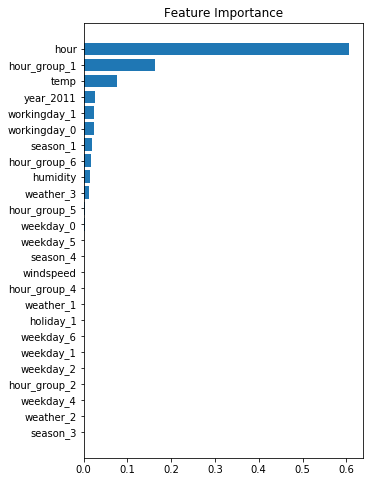

In [50]:
# Get sorted list of features in order of importance
feature_indices = np.argsort(best_gb.feature_importances_)
importances = best_gb.feature_importances_
indices = np.argsort(importances)[::1]
names = [X_train.columns[i] for i in indices]
# Create plot
plt.figure(figsize=(5,8))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.barh(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.yticks(range(X_train.shape[1]), names)

# Show plot
plt.show()

ExtraTrees

In [51]:
rmsle_scores = []
rmsle_scores_train = []
for train_index, test_index in skf.split(X_train):
    
    print('')
    print("Train:", train_index, "Validation:",test_index)
    train, test = X_train.iloc[train_index], X_train.iloc[test_index] 
    traintarget, testtarget = y_train.iloc[train_index], y_train.iloc[test_index]

    best_et = ExtraTreesRegressor(n_estimators=300,
                                  max_depth=20 ,min_samples_split=3)
    best_et.fit(train, traintarget)
    
    train_predictions = best_et.predict(train)
    train_rmsle = rmsle(np.exp(train_predictions),np.exp(traintarget),False)
    print("Train RMSLE Score Tunned ET: " ,train_rmsle)
    rmsle_scores_train.append(train_rmsle)
    
    val_predictions = best_et.predict(test)
    val_rmsle = rmsle(np.exp(val_predictions),np.exp(testtarget),False)
    print("Validation RMSLE Score Tunned ET: " ,val_rmsle)
    print('')
    
    rmsle_scores.append(val_rmsle)
    testtarget = np.exp(testtarget)
    val_predictions = np.exp(val_predictions)
    df = pd.DataFrame(data={'act':testtarget,'pred':val_predictions})
    print(df.head())

print('')    
print('rmsle train')
display_scores(np.asarray(rmsle_scores_train))
print('')    
print('rmsle test')
display_scores(np.asarray(rmsle_scores))
print('')


Train: [ 2178  2179  2180 ... 10883 10884 10885] Validation: [   0    1    2 ... 2175 2176 2177]
Train RMSLE Score Tunned ET:  0.0502650170099646
Validation RMSLE Score Tunned ET:  0.6964489702187444

    act       pred
0  17.0  68.757088
1  41.0  48.522418
2  33.0  44.201929
3  14.0  15.506121
4   2.0   7.416079

Train: [    0     1     2 ... 10883 10884 10885] Validation: [2178 2179 2180 ... 4352 4353 4354]
Train RMSLE Score Tunned ET:  0.05436522946247536
Validation RMSLE Score Tunned ET:  0.37384708853668713

        act        pred
2178  291.0  252.435027
2179  605.0  502.514702
2180  481.0  483.154613
2181  350.0  369.760881
2182  284.0  173.741760

Train: [    0     1     2 ... 10883 10884 10885] Validation: [4355 4356 4357 ... 6529 6530 6531]
Train RMSLE Score Tunned ET:  0.053656994598054564
Validation RMSLE Score Tunned ET:  0.5031811973475607

        act        pred
4355  106.0  142.304284
4356  163.0  147.928018
4357  134.0  189.353225
4358  156.0  190.446355
4359  277.0 

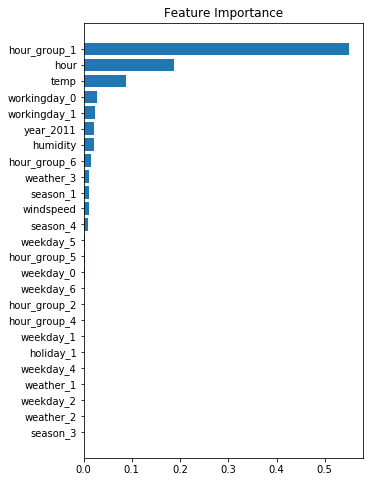

In [52]:
# Get sorted list of features in order of importance
feature_indices = np.argsort(best_rf.feature_importances_)
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::1]
names = [X_train.columns[i] for i in indices]
# Create plot
plt.figure(figsize=(5,8))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.barh(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.yticks(range(X_train.shape[1]), names)

# Show plot
plt.show()

Top Model

Choose top 2 model from the tuned model based on error

The two model is

1. LightGBM 0.34593181705891807
2. XGBoost 0.3532226919692255

# Averaging

averaging is the method which get the predicted result from the average result of the two best model

In [53]:
rmsle_scores = []
rmsle_scores_train = []

for train_index, test_index in skf.split(X_train):
    
    print('')
    print("Train:", train_index, "Validation:",test_index)
    train, test = X_train.iloc[train_index], X_train.iloc[test_index] 
    traintarget, testtarget = y_train.iloc[train_index], y_train.iloc[test_index]

    best_xgb =xgb.XGBRegressor(
       colsample_bytree=0.4, gamma=0.2, 
                             learning_rate=0.05, max_depth=4, 
                              n_estimators=3000
    )
    best_xgb.fit(train, traintarget)
    
    best_lgb =  lgb.LGBMRegressor(
        objective='regression',learning_rate=0.01, 
                                  n_estimators=2000, num_leaves=40, 
                                  max_depth=8, colsample_bytree=0.3)
    best_lgb.fit(train, traintarget)
    xgb_predictions = best_xgb.predict(train)
    lgb_predictions = best_lgb.predict(train)
    
    train_predictions = 0.5*xgb_predictions + 0.5*lgb_predictions
    train_rmsle = rmsle(np.exp(train_predictions),np.exp(traintarget),False)
    print("Train RMSLE Score Averaging: " ,train_rmsle)
    rmsle_scores_train.append(train_rmsle)
    
    val_xgb_predictions = best_xgb.predict(test)
    val_lgb_predictions = best_lgb.predict(test)
    val_predictions = 0.5*val_xgb_predictions + 0.5*val_lgb_predictions
    val_rmsle = rmsle(np.exp(val_predictions),np.exp(testtarget),False)
    
    print("Validation RMSLE Score Averaging: " ,val_rmsle)
    print('')
    
    rmsle_scores.append(val_rmsle)
    testtarget = np.exp(testtarget)
    val_predictions = np.exp(val_predictions)
    df = pd.DataFrame(data={'act':testtarget,'pred':val_predictions})
    print(df.head())

print('')    
print('rmsle train')
display_scores(np.asarray(rmsle_scores_train))
print('')    
print('rmsle test')
display_scores(np.asarray(rmsle_scores))
print('')


Train: [ 2178  2179  2180 ... 10883 10884 10885] Validation: [   0    1    2 ... 2175 2176 2177]
[12:44:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSLE Score Averaging:  0.21490908388199914
Validation RMSLE Score Averaging:  0.5513087412234676

    act       pred
0  17.0  51.061413
1  41.0  36.921327
2  33.0  27.293158
3  14.0  13.641923
4   2.0   5.013408

Train: [    0     1     2 ... 10883 10884 10885] Validation: [2178 2179 2180 ... 4352 4353 4354]
[12:45:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSLE Score Averaging:  0.23446886179380438
Validation RMSLE Score Averaging:  0.2799088578763573

        act        pred
2178  291.0  242.050971
2179  605.0  478.533434
2180  481.0  447.577991
2181  350.0  323.377408
2182  284.0  177.804148

Train: [    0     1     2 ... 10883 10884 10885] Validation: [4355 4356 4357 ... 

# Stacking 

Stacking is the method of predicted result with build model by train or make new model based on the 2 result of the tunned best model

In [54]:
model1 = xgb.XGBRegressor(
       colsample_bytree=0.4, gamma=0.2, 
                             learning_rate=0.05, max_depth=4, 
                              n_estimators=3000)
model2 = lgb.LGBMRegressor(
        objective='regression',learning_rate=0.01, 
                                  n_estimators=2000, num_leaves=40, 
                                  max_depth=8, colsample_bytree=0.3)

    
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
y_train1 = model1.predict(X_train)
y_train2 = model2.predict(X_train)
y_test1 = model1.predict(X_test)
y_test2 = model2.predict(X_test)


datastack = pd.DataFrame(data={'y_1':y_train1,
                               'y_2':y_train2,
                               'y_train':y_train
                              })

teststack = pd.DataFrame(data={'y_1':y_test1,
                               'y_2':y_test2
                              })

data_tr = datastack.drop(['y_train'],axis =1)
train_target = datastack.y_train

[12:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [55]:
rmsle_scores = []
rmsle_scores_train = []
for train_index, test_index in skf.split(data_tr):
    
    print('')
    print("Train:", train_index, "Validation:",test_index)
    train, test = data_tr.iloc[train_index], data_tr.iloc[test_index] 
    traintarget, testtarget = train_target.iloc[train_index], train_target.iloc[test_index]

    best_stc =   xgb.XGBRegressor(
       colsample_bytree=0.3, gamma=0.3, 
                             learning_rate=0.01, 
                              n_estimators=2000)
    
    best_stc.fit(train, traintarget)
    train_predictions = best_stc.predict(train)
    train_rmsle = rmsle(np.exp(train_predictions),np.exp(traintarget),False)
    print("Train RMSLE Score Stacked: " ,train_rmsle)
    rmsle_scores_train.append(train_rmsle)
    
    val_predictions = best_stc.predict(test)
    val_rmsle = rmsle(np.exp(val_predictions),np.exp(testtarget),False)
    print("Validation RMSLE Score Stacked: " ,val_rmsle)
    print('')
    
    rmsle_scores.append(val_rmsle)
    testtarget = np.exp(testtarget)
    val_predictions = np.exp(val_predictions)
    df = pd.DataFrame(data={'act':testtarget,'pred':val_predictions})
    print(df.head())

print('')    
print('rmsle train')
display_scores(np.asarray(rmsle_scores_train))
print('')    
print('rmsle test')
display_scores(np.asarray(rmsle_scores))
print('')


Train: [ 2178  2179  2180 ... 10883 10884 10885] Validation: [   0    1    2 ... 2175 2176 2177]
[12:47:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSLE Score Stacked:  0.2173625078679617
Validation RMSLE Score Stacked:  0.2763901845969157

    act       pred
0  17.0  30.278389
1  41.0  25.167849
2  33.0  19.847895
3  14.0   8.746161
4   2.0   3.098134

Train: [    0     1     2 ... 10883 10884 10885] Validation: [2178 2179 2180 ... 4352 4353 4354]
[12:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSLE Score Stacked:  0.23002024301405405
Validation RMSLE Score Stacked:  0.22703640455292362

        act        pred
2178  291.0  250.521271
2179  605.0  494.651581
2180  481.0  457.608154
2181  350.0  348.507782
2182  284.0  207.665665

Train: [    0     1     2 ... 10883 10884 10885] Validation: [4355 4356 4357 ... 6529 653

From the avereging and stacking method, stacking method is the method wtih the lowest error, and this method also have the lowest if we compare with another method .

So we choose this stacking method to predict the demand of bike share system

# Predict Final Model

In [56]:
modelstack =   xgb.XGBRegressor(
       colsample_bytree=0.3, gamma=0.3, 
                             learning_rate=0.01, 
                              n_estimators=2000)
modelstack.fit(data_tr, train_target)
y_test = modelstack.predict(teststack)

y_test = np.expm1(y_test)
output = pd.DataFrame({'datetime': test_data.datetime,
                       'count': y_test})
output.to_csv('submission-final.csv', index=False)

[12:48:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
